# ATIAM Projet ML 2023 - 2024
## $\alpha$-(de)blending
### Athor: Paul TRIANA
### Superviser: Nils Demerlé

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import torch
import torch.nn as nn
from sklearn.datasets import make_swiss_roll
from torch.utils.data import DataLoader

#### Defining Iterative $\alpha$-(De)Blending (IADB) model

In [10]:
class Positional_Encoding(nn.Module):
    
    def __init__(self, input_dim, max_steps = 10000):
        super(Positional_Encoding, self).__init__()
        self.input_dim = input_dim
        self.omega = (max_steps / (max_steps ** (2 * torch.arange(self.input_dim//2)/self.input_dim))).view(self.input_dim//2, 1)
        self.max_steps = max_steps

    def sin_cos(self, a, i):
        if i:
            return torch.cos(a)
        else:
            return torch.sin(a)

    def forward(self, alpha):
        alpha = alpha.view(1, alpha.shape[0])
        alpha = [self.sin_cos(alpha/(self.max_steps**(2*(k//2)/self.input_dim)),k%2) for k in range(self.input_dim)]
        pos_enc = torch.cat(alpha)
        return torch.transpose(pos_enc,0,1)

class IADB(nn.Module):

    def __init__(self, dim, max_steps = 2, negative_slope = 0.01):
        super(IADB, self).__init__()
        self.dim = dim
        self.enc_dim = dim
        self.pos_enc = Positional_Encoding(self.enc_dim, max_steps=max_steps)
        self.negative_slope = negative_slope
        #self.activation = nn.LeakyReLU(negative_slope=self.negative_slope)
        self.activation = nn.ReLU()
        self.l1 = nn.Linear(self.dim + self.enc_dim, 64)
        self.l2 = nn.Linear(64 + self.enc_dim, 128)
        self.l3 = nn.Linear(128 + self.enc_dim, 128)
        self.l5 = nn.Linear(128 + self.enc_dim, 64)
        self.l6 = nn.Linear(64 + self.enc_dim, self.dim)
        

    def forward(self, x, t):
        pos_enc = self.pos_enc(t).to(torch.float32)
        x = self.activation(self.l1(torch.cat((x,pos_enc), dim=1)))
        x = self.activation(self.l2(torch.cat((x,pos_enc), dim=1)))
        x = self.activation(self.l3(torch.cat((x,pos_enc), dim=1)))
        x = self.activation(self.l5(torch.cat((x,pos_enc), dim=1)))
        return self.l6(torch.cat((x,pos_enc), dim=-1))
    
    def sample(self, T, n_samples = 1000):
        x_0 = torch.randn((n_samples,2))
        denoised_samples = [x_0]
        alpha = torch.arange(T)/T
        for t in range(1,T,1):
            x_a = denoised_samples[-1] + (alpha[t] - alpha[t-1])*self.forward(denoised_samples[-1],alpha[t]*torch.ones(n_samples,1))
            denoised_samples.append(x_a)
        return denoised_samples
        

#### Defining data

In [11]:
def get_dataset(N = 50000):
    img = mpimg.imread("../../resources/datasets/images/acids.png")

    img = (img * 255).astype(np.uint8)
    print(img.shape)

    img = Image.fromarray(img).convert('L')
    gray_array = np.asarray(img)

    positions = np.random.rand(2, N)
    closest_idx = positions.copy()
    closest_idx[0] *= gray_array.shape[0]
    closest_idx[1] *= gray_array.shape[1]
    closest_idx = closest_idx.astype(int)
    density = np.zeros((N))

    for i in range(N):
        p1 = closest_idx[:, i]
        density[i] = (gray_array[459-p1[1], p1[0]] - 105)/138


    probs = np.random.rand(N)
    positions_final = positions[:,probs>density]    
    return torch.from_numpy(positions_final.T).float()*10-5

(460, 460, 3)


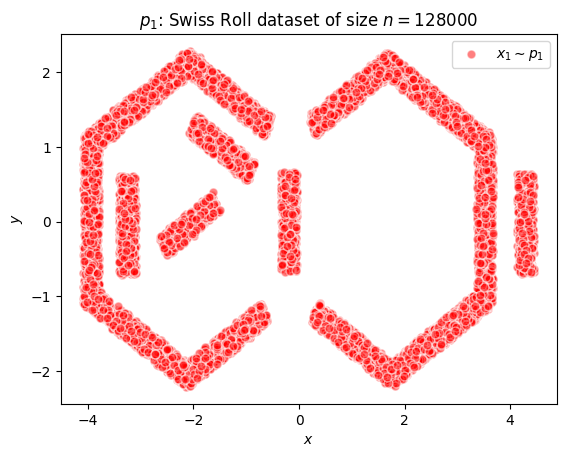

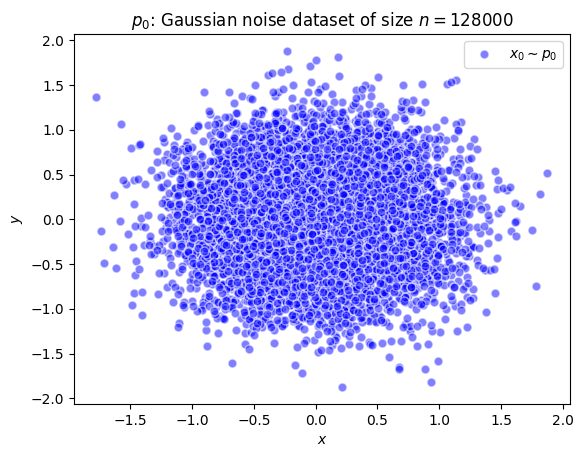

In [12]:
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0

batch_size = 128
n_batches_train = int(1e3)
n_data_train = n_batches_train * batch_size
#x_1_train = torch.from_numpy(sample_batch(n_data_train))
x_1_train = get_dataset(N = n_data_train)
x_0_train = torch.randn_like(x_1_train)*0.5

plt.figure()
plt.scatter(*x_1_train.T, alpha=0.5, color='red', edgecolor='white', s=40, label=r'$x_1 \sim p_1$')
plt.title(r'$p_1$: Swiss Roll dataset of size $n = {len}$'.format(len = n_data_train))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

plt.figure()
plt.scatter(*x_0_train.T, alpha=0.5, color='blue', edgecolor='white', s=40, label=r'$x_0 \sim p_0$')
plt.title(r'$p_0$: Gaussian noise dataset of size $n = {len}$'.format(len = n_data_train))
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.legend()
plt.show()

#### Training model

In [13]:
model = IADB(2)
n_epochs = 20000
loss_function = nn.MSELoss(reduction='mean')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

epoch 1, training loss: 4.203690528869629
epoch 4001, training loss: 1.4331596215645392
epoch 8001, training loss: 1.424131850262622


KeyboardInterrupt: 

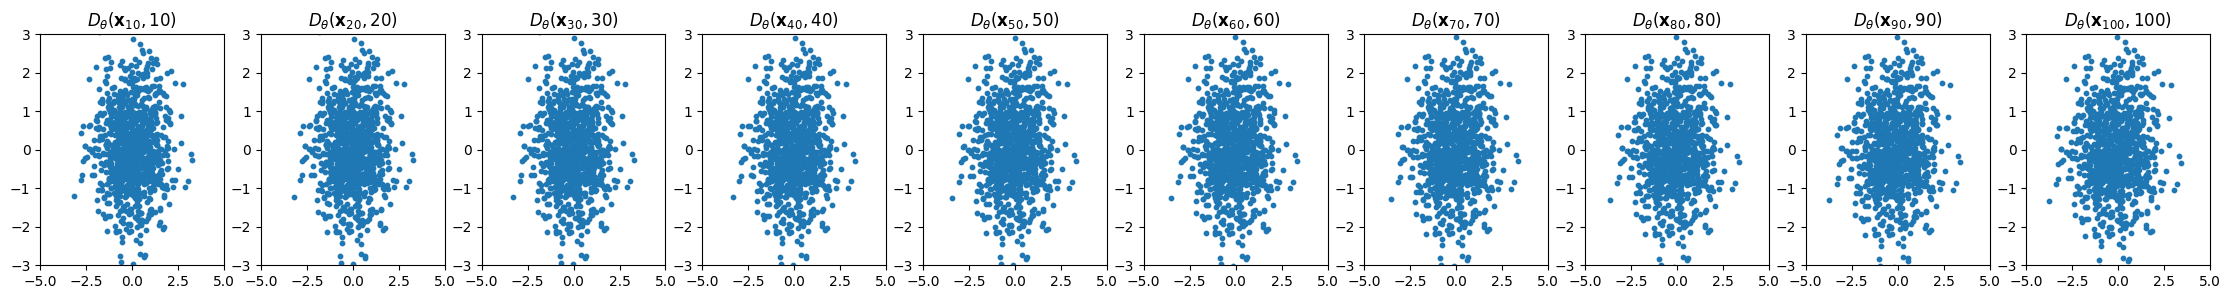

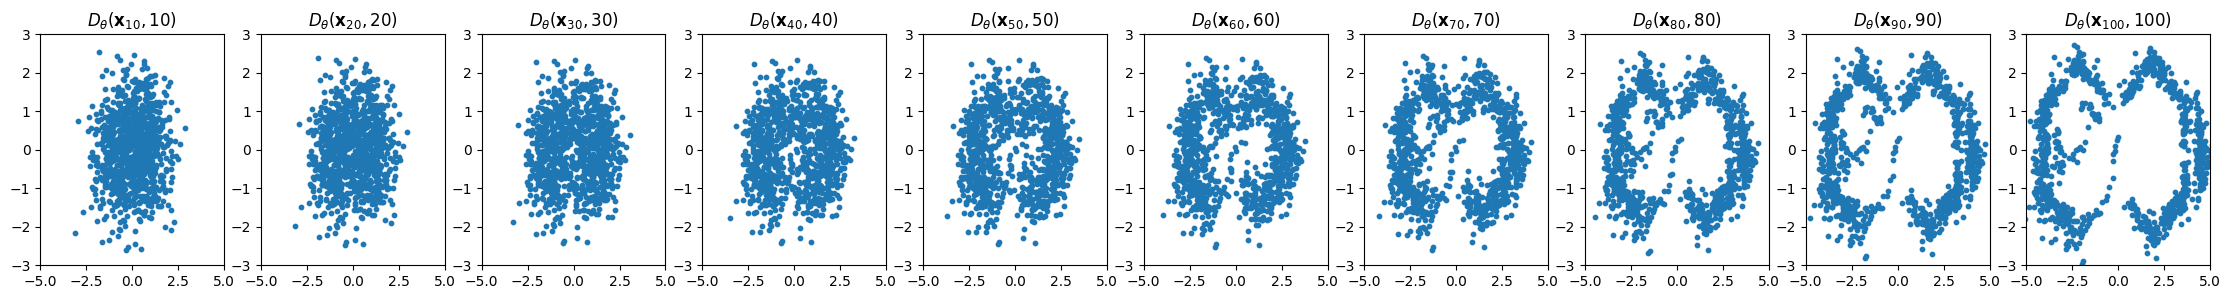

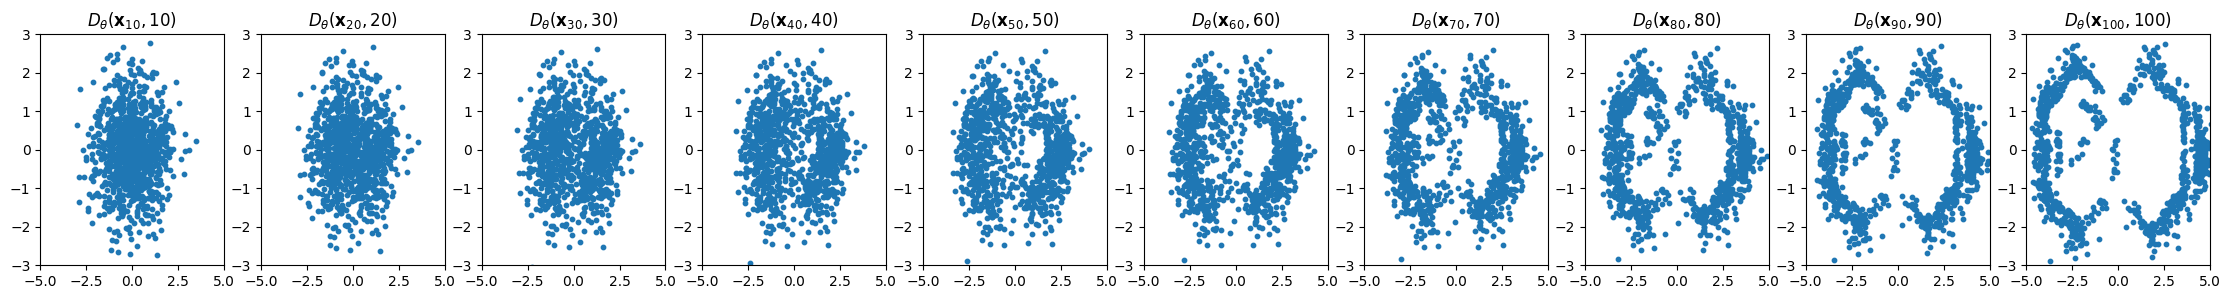

In [14]:
training_loss = []
test_loss = []
T = 100
for n in range(n_epochs):

    # Resample in P_0 to increade data richness 
    x_0_train = torch.randn_like(x_1_train)*0.5

    for k in range(0, n_batches_train, batch_size):
        x_1 = x_1_train[k: k + batch_size].view(batch_size, 2)
        x_0 = x_0_train[k: k + batch_size].view(batch_size, 2)
        a = torch.rand(batch_size, 1)
        x_a = ((1 - a)*x_0 + a*x_1).to(torch.float32)
        average_diff_model = model(x_a, a)
        real_average_diff = (x_1 - x_0).to(torch.float32)
        optimizer.zero_grad()
        loss = loss_function(average_diff_model, real_average_diff)
        loss.backward()
        optimizer.step()
    
    training_loss.append(loss.item())

    if (n % (n_epochs // 5) == 0):
        print('epoch {n}, training loss: {l}'.format(l=np.mean(training_loss[np.max((0,n-1000)):n+1]),  n=n+1))
        x_seq = model.sample(T, n_samples = 1000)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            a = i * T//10
            cur_x = x_seq[a-1].detach().numpy()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1], s=10)
            axs[i-1].set_title(r'$D_{\theta}(\mathbf{x}_{'+str(a)+r'},'+ str(a) +r')$')
            axs[i-1].set_ylim([-3,3])
            axs[i-1].set_xlim([-5,5])

#### Biliography

<a id="ref1"/>

[1] [Eric Heitz, Laurent Belcour, and Thomas Chambon. Iterative alpha-(de)blending: a minimalist deterministic diffusion model. arXiv preprint arXiv:2305.03486, 2023.](https://arxiv.org/pdf/2305.03486.pdf)

<a id="ref2"/>

[2] [Kazemnejad A. (2019, September). Amirhossein Kazemnejad's Blog. Transformer Architecture: The Positional Encoding, Let's use sinusoidal functions to inject the order of words in our model.](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/)